### Introduction
We are going to work on building a regression model that will help to predict the prices and the identify what kind of houses will sell the most based on the past performance of a few attributes.The following will be addresses 
* EDA   
* Engineer and transform the features and the target variable
* Set base to Build a model
* Further make and submit predictions

### Getting the necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
%matplotlib inline 
pd.pandas.set_option('display.max_columns', None)
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


### EDA

In [2]:
kcfe = pd.read_csv('kc_4_fe3') 
kcfe.head(2) 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,1951.0,98178,47.5112,-122.257,1340,5650,2014,10,13,59,0.0,0.2219,2360.0,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,9,63,40.0,0.5380,5140.0,0.0


In [3]:
# checking % of nan value present
# Finding list of features having missing values
features_with_na=[features for features in kcfe.columns if kcfe[features].isnull().sum()>1]
# printing the feature name and missing value
for feature in features_with_na:
    print(feature,np.round(kcfe[feature].isnull().mean(),6), '%missing vales')  #upto 6 decimal place

#### Finding relationship between each column having missing value and sales price

In [4]:
for feature in features_with_na:
    kc1 = kcfe.copy()
    
    #making variable that indicate 1 if the observation was missing or zero otherwise
    kc1[feature] = np.where(kc1[feature].isnull(), 1, 0)
    
    
    #Calculating the mean Sale price where information is missing or present
    kc1.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()
    
    # Each null value will be ploted in 1 on the x axis

In [5]:
kcfe.nunique() 

id                      21420
price                    3622
bedrooms                   12
bathrooms                  29
sqft_living              1034
sqft_lot                 9776
floors                      6
waterfront                  2
view                        5
condition                   5
grade                      11
sqft_above                942
sqft_basement             303
yr_built                  116
yr_renovated              116
zipcode                    70
lat                      5033
long                      751
sqft_living15             777
sqft_lot15               8682
year                        2
month                      12
day                        31
yr_age_of_house           117
yr_age_of_renovation      114
price_in_millions        3622
sqft_total               1076
view_plus                   6
dtype: int64

#### Confirming all columns as Numerical variables 

In [6]:
#listing all numerical variables
num_features = [feature for feature in kcfe.columns if kcfe[feature].dtypes != 'O']  #'O' is for object
print('Number of numerical variables: ', len(num_features))
#visualising the columns of the data
kcfe[num_features].head() 

Number of numerical variables:  28


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,1951.0,98178,47.5112,-122.257,1340,5650,2014,10,13,59,0.0,0.2219,2360.0,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,9,63,40.0,0.5380,5140.0,0.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,2015,2,25,82,0.0,0.1800,1540.0,0.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,1987.0,98136,47.5208,-122.393,1360,5000,2014,12,9,49,22.0,0.6040,3920.0,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,2001.0,98074,47.6168,-122.045,1800,7503,2015,2,18,28,14.0,0.5100,3360.0,0.0


In [7]:
kcfe.describe() 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007316,0.233412,3.409825,7.657915,1788.596842,285.716581,1970.999676,1972.031717,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,2014.322962,6.573969,15.687457,43.323286,12.767560,0.540297,4154.635273,0.240728
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.085221,0.764995,0.650546,1.173200,827.759761,439.819830,29.375234,29.308600,53.513072,0.138552,0.140724,685.230472,27274.441950,0.467619,3.115061,8.634890,29.377285,21.910626,0.367368,1833.745350,0.800232
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,-1.000000,0.000000,0.078000,740.000000,0.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1952.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000,18.000000,0.000000,0.322000,2840.000000,0.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1976.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,2014.000000,6.000000,16.000000,40.000000,0.000000,0.450000,3820.000000,0.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,1998.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,9.000000,23.000000,63.000000,19.000000,0.645000,5100.000000,0.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000,115.000000,114.000000,7.700000,27080.000000,5.000000


### yr_feature

In [8]:
yr_feature = [feature for feature in num_features if 'yr' in feature or 'year' in feature or 'month' in feature or 'day' in feature] 
yr_feature

['yr_built',
 'yr_renovated',
 'year',
 'month',
 'day',
 'yr_age_of_house',
 'yr_age_of_renovation']

In [9]:
for feature in yr_feature:
    print(feature, kcfe[feature].nunique())     

yr_built 116
yr_renovated 116
year 2
month 12
day 31
yr_age_of_house 117
yr_age_of_renovation 114


In [10]:
kcfe.year.min(), kcfe.year.max()  

(2014, 2015)

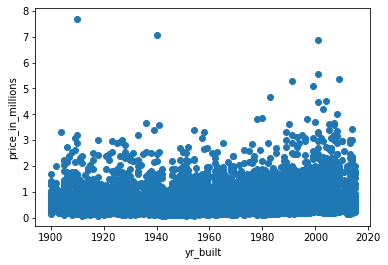

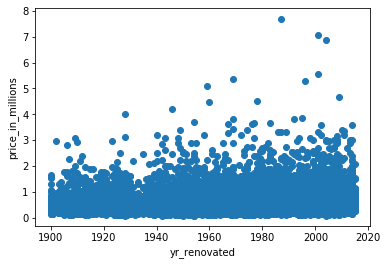

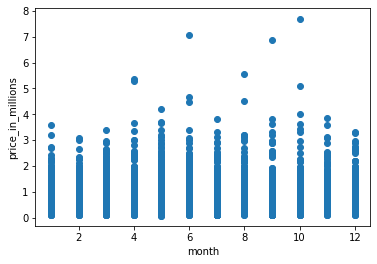

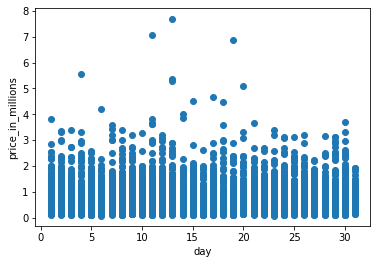

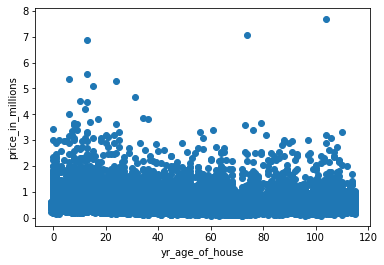

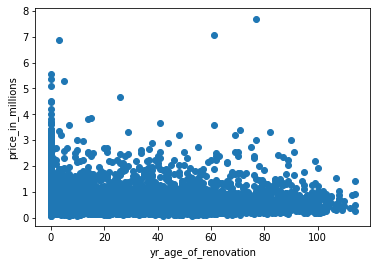

In [11]:
for feature in yr_feature:
    if feature !='year':
        kc1=kcfe.copy()
        plt.scatter(kc1[feature], kc1['price_in_millions']) 
        plt.xlabel(feature)
        plt.ylabel('price_in_millions') 
        plt.show() 

#### Observation : we can see that there are 7 datetime based variables . 
* yr_age_of_house provides us the report that there were more newer houses sold than the older houses


### Continous & Discreate feature
* Two types of numerical variables-Continous + Discreate

In [12]:
discrete_feature = [feature for feature in num_features if len (kcfe[feature].unique())<30 and feature not in yr_feature + ['id']] 

print('Discrete Variable Count: {}'.format(len(discrete_feature))) 

Discrete Variable Count: 8


In [13]:
discrete_feature

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'view_plus']

In [14]:
kcfe[discrete_feature].head() 

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,view_plus
0,3,1.00,1.0,0.0,0.0,3,7,0.0
1,3,2.25,2.0,0.0,0.0,3,7,0.0
2,2,1.00,1.0,0.0,0.0,3,6,0.0
3,4,3.00,1.0,0.0,0.0,5,7,0.0
4,3,2.00,1.0,0.0,0.0,3,8,0.0


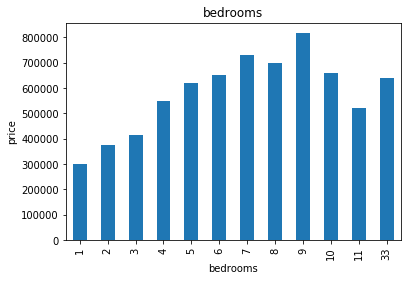

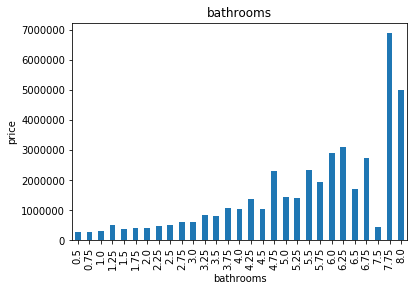

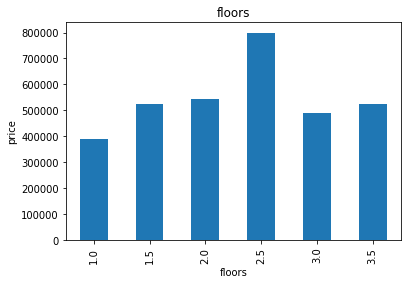

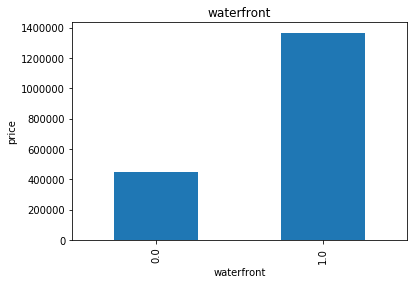

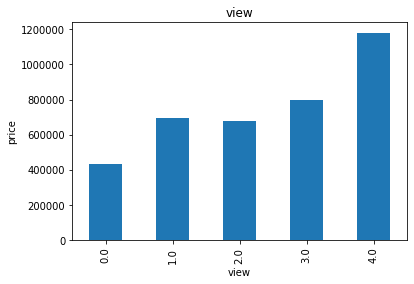

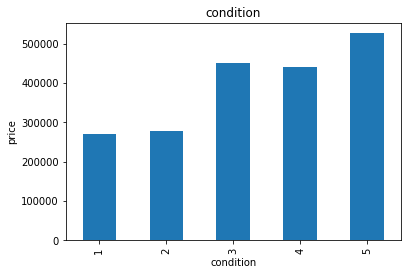

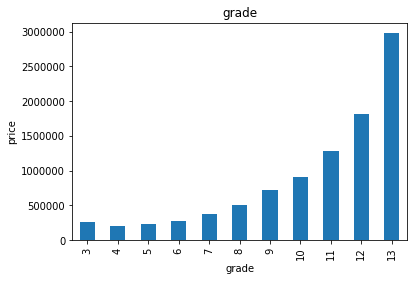

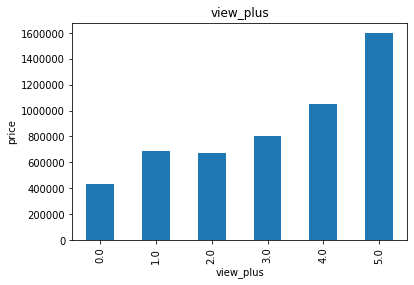

In [15]:
for feature in discrete_feature:
    kc1 = kcfe.copy() 
    kc1.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show() 

In [16]:
continuous_feature = [feature for feature in num_features if feature not in yr_feature + discrete_feature + ['id']] 
print('Continuous Variable Count: {}'.format(len(continuous_feature))) 

Continuous Variable Count: 12


In [17]:
continuous_feature

['price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price_in_millions',
 'sqft_total']

####  Finding distribution of continous feature / variable with histogram

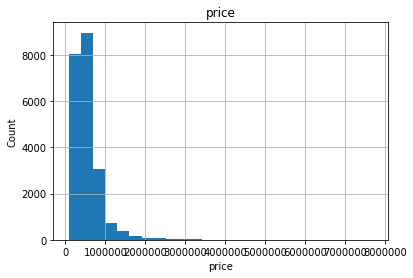

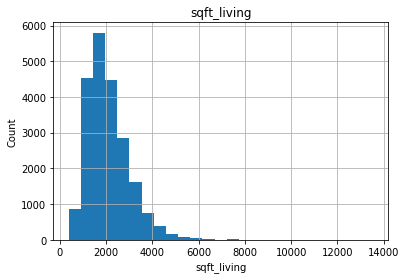

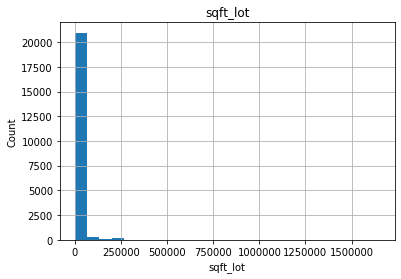

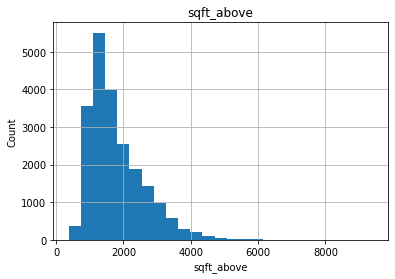

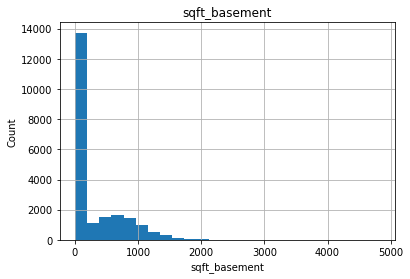

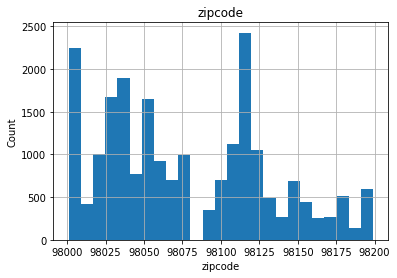

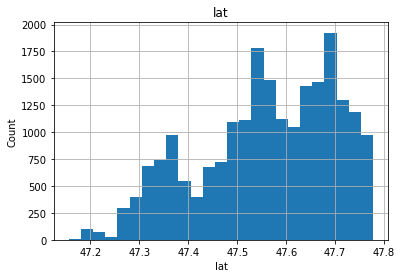

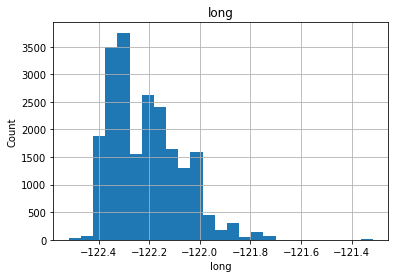

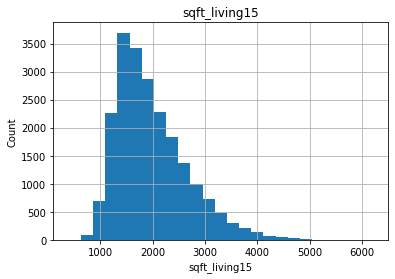

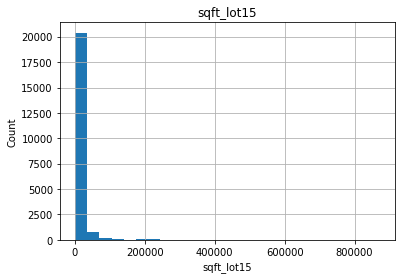

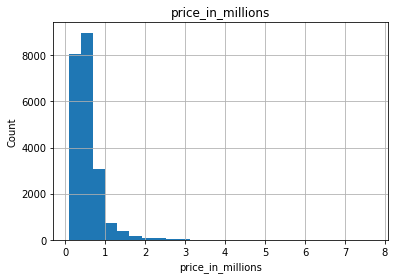

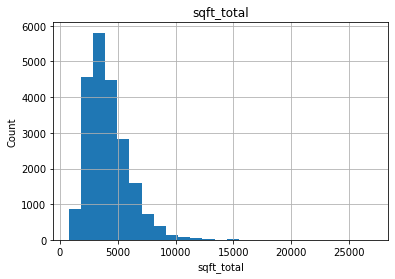

In [18]:
for feature in continuous_feature:
    kc1=kcfe.copy()
    kc1[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

#### Checking the Outliers in the features using Box Plot

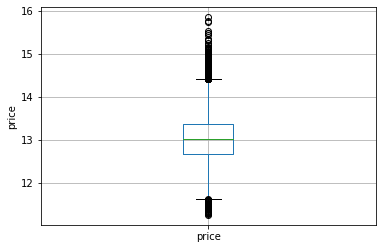

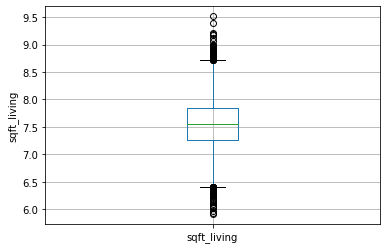

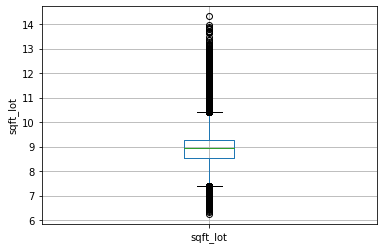

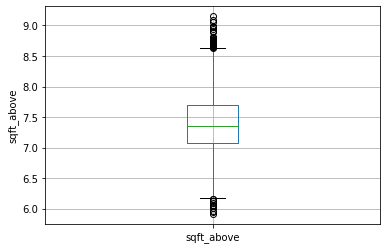

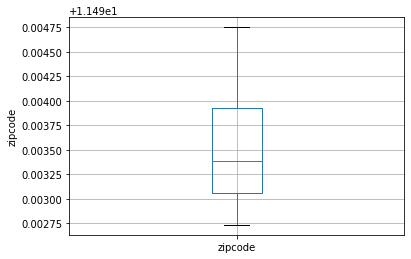

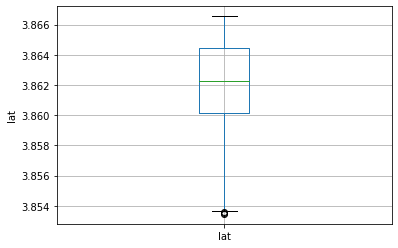

C:\Users\DELL\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


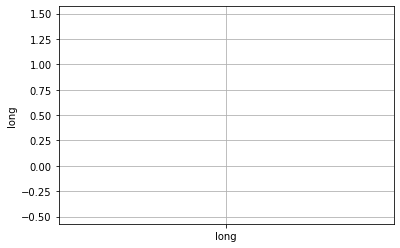

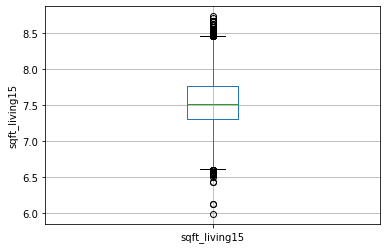

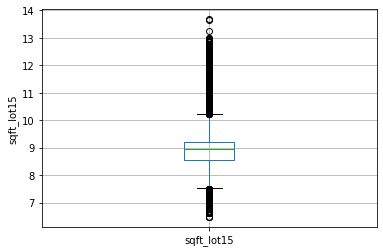

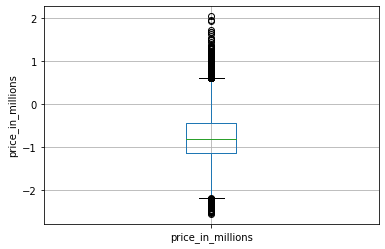

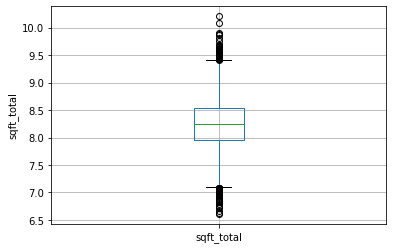

In [19]:
for feature in continuous_feature:
    kc1=kcfe.copy()
    if 0 in kc1[feature].unique():
        pass
    else:
        kc1[feature]=np.log(kc1[feature])
        kc1.boxplot(column=feature)
        plt.ylabel(feature)
        plt.show()      
    

#### Observation 
* Since there are a number of outliers for the said features it will be advisable to use median

##### Locating outliers

In [20]:
kc1.loc[kc1['price'] > 4400000]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
1162,1247600105,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,3,12,5990,2020.0,1999,1959.0,98033,47.6767,-122.211,3430,26788,2014,10,20,15,0.0,5.11,9.681593,5.0
1313,7558700030,5300000.0,6,6.00,7390,24829,2.0,1.0,0.0,4,12,5000,2390.0,1991,1996.0,98040,47.5631,-122.210,4320,24619,2015,4,13,24,5.0,5.30,9.601030,1.0
1446,8907500070,5350000.0,5,5.00,8000,23985,2.0,0.0,4.0,3,12,6720,1280.0,2009,1969.0,98004,47.6232,-122.220,4600,21750,2015,4,13,6,0.0,5.35,9.680344,4.0
2624,7738500731,4500000.0,5,5.50,6640,40014,2.0,1.0,4.0,3,12,6350,290.0,2004,1978.0,98155,47.7493,-122.280,3030,23408,2014,8,15,10,0.0,4.50,9.494014,5.0
3910,9808700762,7060000.0,5,4.50,10040,37325,2.0,1.0,2.0,3,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449,2014,6,11,74,61.0,7.06,9.907480,3.0
4407,2470100110,5570000.0,5,5.75,9200,35069,2.0,0.0,0.0,3,13,6200,3000.0,2001,2001.0,98039,47.6289,-122.233,3560,24345,2014,8,4,13,0.0,5.57,9.820106,0.0
7245,6762700020,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,4,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800,2014,10,13,104,77.0,7.70,10.089967,3.0
8085,1924059029,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,3,12,4820,4820.0,1983,2009.0,98040,47.5570,-122.210,3270,10454,2014,6,17,31,26.0,4.67,9.866824,5.0
8629,3835500195,4490000.0,4,3.00,6430,27517,2.0,0.0,0.0,3,12,6430,0.0,2001,1960.0,98004,47.6208,-122.219,3720,14592,2014,6,18,13,0.0,4.49,9.461877,0.0
9245,9208900037,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,3,13,8860,1030.0,2001,2004.0,98039,47.6305,-122.240,4540,42730,2014,9,19,13,3.0,6.89,9.892427,4.0


In [21]:
kc1.loc[kc1['bedrooms'] > 20]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,1972.0,98103,47.6878,-122.331,1330,4700,2014,6,25,67,25.0,0.64,8.083329,0.0


In [22]:
kc1.loc[kc1['sqft_total'] > 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
7245,6762700020,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,4,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800,2014,10,13,104,77.0,7.70,10.089967,3.0
12764,1225069038,2280000.0,7,8.0,13540,307752,3.0,0.0,4.0,3,12,9410,4130.0,1999,1987.0,98053,47.6675,-121.986,4850,217800,2014,5,5,15,0.0,2.28,10.206551,4.0


In [23]:
kc1.loc[kc1['sqft_living'] > 6000]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
419,8678500060,1550000.0,5,4.25,6070,171626,2.0,0.0,0.0,3,12,6070,0.0,1999,1941.0,98024,47.5954,-121.950,4680,211267,2014,7,10,15,0.0,1.55,9.404261,0.0
527,3225079035,1600000.0,6,5.00,6050,230652,2.0,0.0,3.0,3,11,6050,0.0,2001,1944.0,98024,47.6033,-121.943,4210,233971,2014,6,18,13,0.0,1.60,9.400961,3.0
577,1526069135,930000.0,4,4.00,6050,84942,2.5,0.0,2.0,3,9,4150,1900.0,2009,2004.0,98077,47.7466,-122.029,2700,199504,2014,12,11,5,0.0,0.93,9.400961,2.0
1099,7237500390,1570000.0,5,4.50,6070,14731,2.0,0.0,0.0,3,11,6070,0.0,2004,2004.0,98059,47.5306,-122.134,4750,13404,2014,11,10,10,0.0,1.57,9.404261,0.0
1162,1247600105,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,3,12,5990,2020.0,1999,1959.0,98033,47.6767,-122.211,3430,26788,2014,10,20,15,0.0,5.11,9.681593,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,424069279,1180000.0,6,6.50,6260,10955,2.0,0.0,0.0,3,11,4840,1420.0,2007,2012.0,98075,47.5947,-122.039,2710,12550,2015,3,28,8,5.0,1.18,9.435083,0.0
20822,3425069117,1280000.0,6,5.25,6160,27490,2.0,0.0,0.0,3,11,4040,2120.0,2007,2014.0,98074,47.6094,-122.023,4225,9100,2014,8,28,7,7.0,1.28,9.418979,0.0
21034,2424059170,900000.0,5,6.00,7120,40806,2.0,0.0,4.0,3,12,5480,1640.0,2007,2006.0,98006,47.5451,-122.114,3440,36859,2015,2,19,8,0.0,0.90,9.563810,4.0
21328,8835770170,1490000.0,5,6.00,6880,279968,2.0,0.0,3.0,3,12,4070,2810.0,2007,2007.0,98045,47.4624,-121.779,4690,256803,2014,8,22,7,0.0,1.49,9.529521,3.0


##### Dropping Outliers

In [24]:
kc1 = kc1[kc1.bedrooms != 33]
kc1 = kc1[kc1.price < 3500000]
kc1 = kc1[kc1.sqft_living < 6000]

In [25]:
kc1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21519 entries, 0 to 21596
Data columns (total 28 columns):
id                      21519 non-null int64
price                   21519 non-null float64
bedrooms                21519 non-null int64
bathrooms               21519 non-null float64
sqft_living             21519 non-null int64
sqft_lot                21519 non-null int64
floors                  21519 non-null float64
waterfront              21519 non-null float64
view                    21519 non-null float64
condition               21519 non-null int64
grade                   21519 non-null int64
sqft_above              21519 non-null int64
sqft_basement           21519 non-null float64
yr_built                21519 non-null int64
yr_renovated            21519 non-null float64
zipcode                 21519 non-null int64
lat                     21519 non-null float64
long                    21519 non-null float64
sqft_living15           21519 non-null int64
sqft_lot15        

#### Checking Histograms pre feature engineering

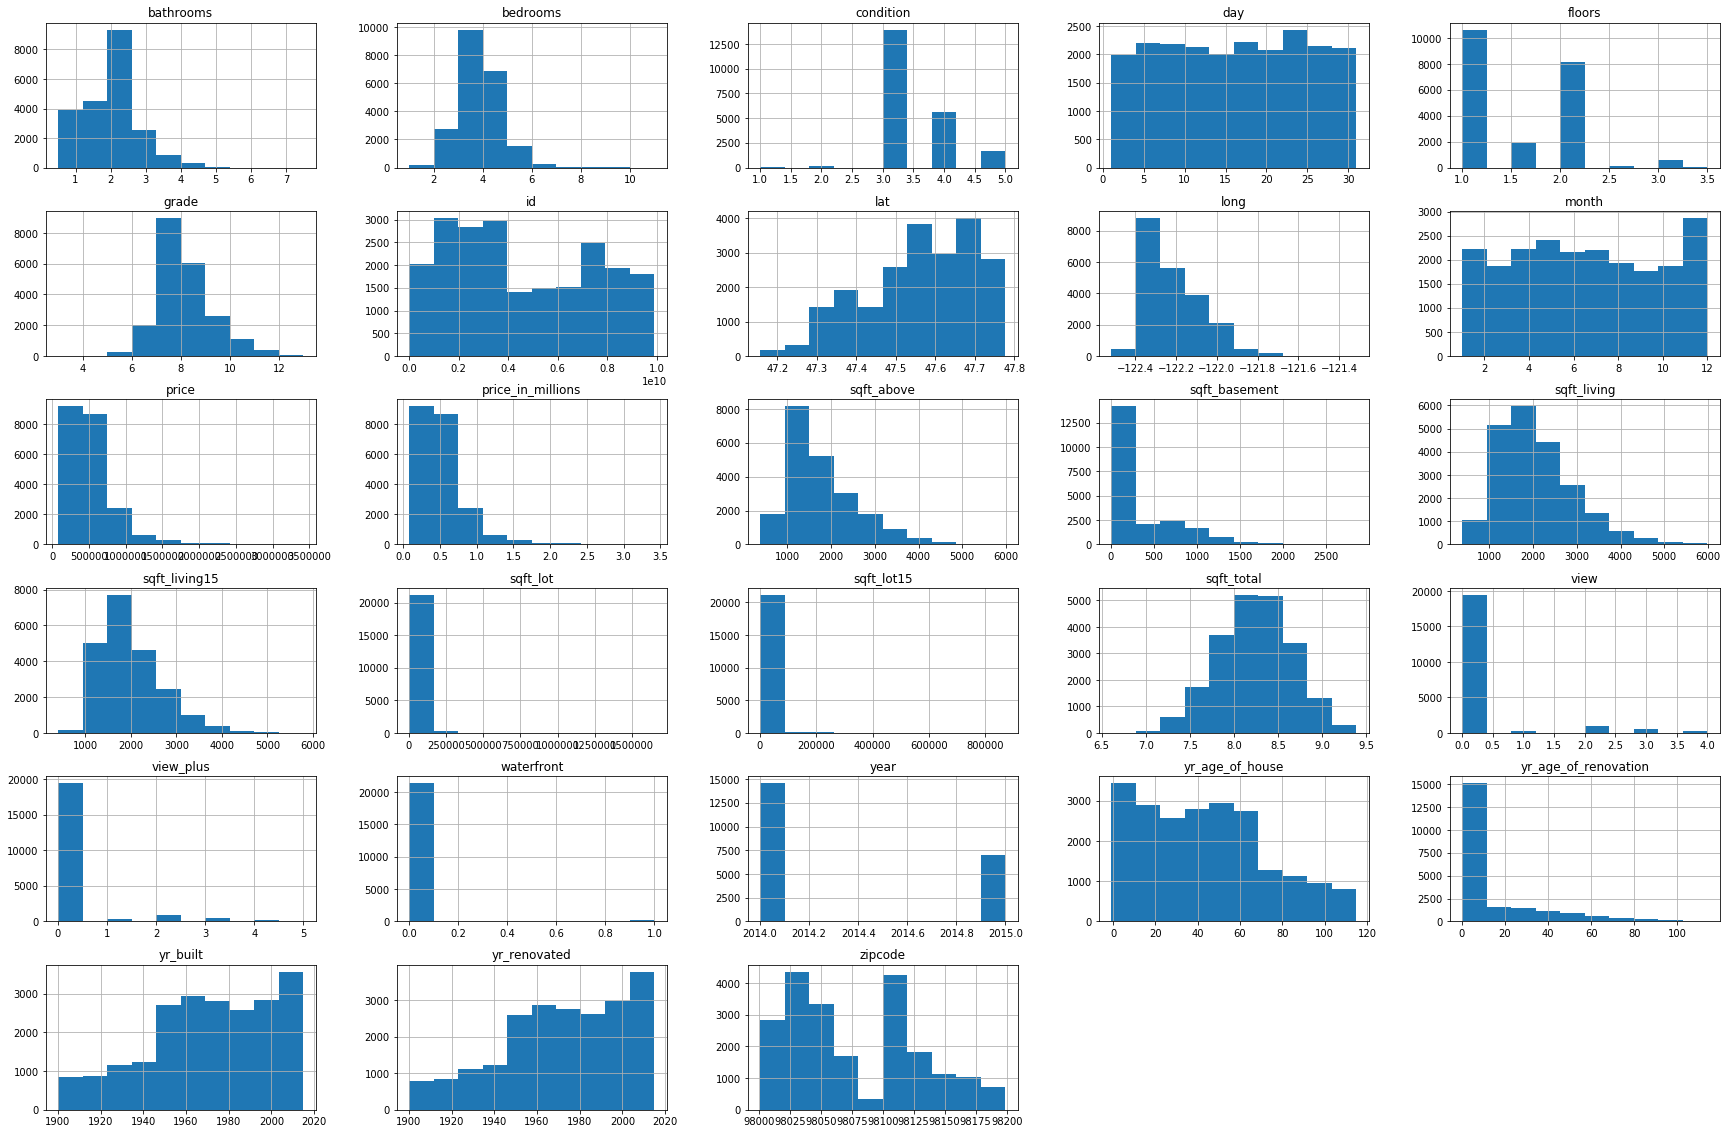

In [26]:
kc1.hist(figsize=(30,20))
plt.show()

In [27]:
# For checking nan values  
features_nan = [feature for feature in kc1.columns if kc1[feature].isnull().sum()>1 and kc1[feature].dtypes == 'O'] 

for feature in features_nan:
    print("{}:{}% missing values".format(feature,np.round(kc1[feature].isnull().mean(),2))) ## upto two decimal place

In [28]:
## to replace missing values

def replace_cat_feature(kcfe,features_nan):
    kcfe1=kc1.copy()
    kcfe1[features_nan]=kcfe1[features_nan].fillna('missing')
    return kcfe1
kc1=replace_cat_feature(kcfe,features_nan)
kc1[features_nan].isnull().sum() 

Series([], dtype: float64)

In [29]:
# For checking nan values  
num_nan = [feature for feature in kc1.columns if kc1[feature].isnull().sum()>1 and kc1[feature].dtypes != 'O'] 

for feature in num_nan:
    print("{}:{}% missing values".format(feature,np.round(kcfe[feature].isnull().mean(),2))) ## upto two decimal place

In [30]:
## replacing numerical missing value
for feature in num_nan:
    ## replacing using median to take care of outliers
    median_value=kc1[feature].median() 
    ## creating a new feature to capture nan values
    kc1[feature+'nan']=np.where(kc1[feature].isnull(),1,0)
    kc1[feature].fillna(median_value,inplace=True)
kc1[num_nan].isnull().sum() 

Series([], dtype: float64)

In [31]:
kc1[yr_feature].head(2) 

,yr_built,yr_renovated,year,month,day,yr_age_of_house,yr_age_of_renovation
0,1955,1951.0,2014,10,13,59,0.0
1,1951,1991.0,2014,12,9,63,40.0


In [32]:
kc1[num_features].head(2)  

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,1951.0,98178,47.5112,-122.257,1340,5650,2014,10,13,59,0.0,0.2219,7.766417,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,9,63,40.0,0.5380,8.544808,0.0


In [33]:
for feature in ['yr_built','yr_renovated']:
    kc1[feature]=kc1['year']-kc1[feature] 

In [34]:
kc1.head(2) 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,59,63.0,98178,47.5112,-122.257,1340,5650,2014,10,13,59,0.0,0.2219,7.766417,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,63,23.0,98125,47.7210,-122.319,1690,7639,2014,12,9,63,40.0,0.5380,8.544808,0.0


In [35]:
kc1.describe() 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
count,2.151900e+04,2.151900e+04,21519.000000,21519.000000,21519.000000,2.151900e+04,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000,21519.000000
mean,4.582123e+09,5.322327e+05,3.366467,2.106139,2062.929411,1.489276e+04,1.492286,0.006738,0.227985,3.410149,7.644036,1775.397695,281.743622,43.383010,42.317998,98078.035922,47.559930,-122.214189,1980.533993,12614.397649,2014.323296,6.572657,15.686974,43.383010,12.779869,0.532233,8.237899,0.234723
std,2.876972e+09,3.309434e+05,0.899134,0.749828,868.247990,4.072415e+04,0.539077,0.081812,0.754190,0.650810,1.150682,795.059371,430.538239,29.365994,29.327260,53.503533,0.138707,0.140681,676.104705,26398.580393,0.467745,3.115076,8.637717,29.365994,21.914635,0.330943,0.417756,0.787172
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,-1.000000,-1.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,-1.000000,0.000000,0.078000,6.606650,0.000000
25%,2.123049e+09,3.209500e+05,3.000000,1.625000,1420.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,18.000000,16.000000,98033.000000,47.470300,-122.329000,1484.000000,5100.000000,2014.000000,4.000000,8.000000,18.000000,0.000000,0.320950,7.951559,0.000000
50%,3.904950e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.600000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,40.000000,38.000000,98065.000000,47.571700,-122.231000,1840.000000,7619.000000,2014.000000,6.000000,16.000000,40.000000,0.000000,0.450000,8.242756,0.000000
75%,7.312050e+09,6.400000e+05,4.000000,2.500000,2540.000000,1.060950e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,540.000000,63.000000,62.000000,98118.000000,47.678100,-122.125000,2360.000000,10050.000000,2015.000000,9.000000,23.000000,63.000000,19.000000,0.640000,8.533067,0.000000
max,9.900000e+09,3.420000e+06,11.000000,7.500000,5990.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,5990.000000,2850.000000,115.000000,115.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,2015.000000,12.000000,31.000000,115.000000,114.000000,3.420000,9.390994,5.000000


### Creating log normal distribution

In [36]:
num_features = ['bedrooms','sqft_lot','floors','sqft_living15','sqft_lot15', 'sqft_living', 'sqft_above', 'price','sqft_total','condition','grade']
for feature in num_features:
    kcfe[feature]=np.log(kcfe[feature]) 

In [37]:
kc1.head(2) 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,59,63.0,98178,47.5112,-122.257,1340,5650,2014,10,13,59,0.0,0.2219,7.766417,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,63,23.0,98125,47.7210,-122.319,1690,7639,2014,12,9,63,40.0,0.5380,8.544808,0.0


### Feature Scaling

In [38]:
feature_scale = [feature for feature in kc1.columns if feature not in ['id','price']]
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler()
mmscaler.fit(kc1[feature_scale])  

MinMaxScaler(copy=True, feature_range=(0, 1))

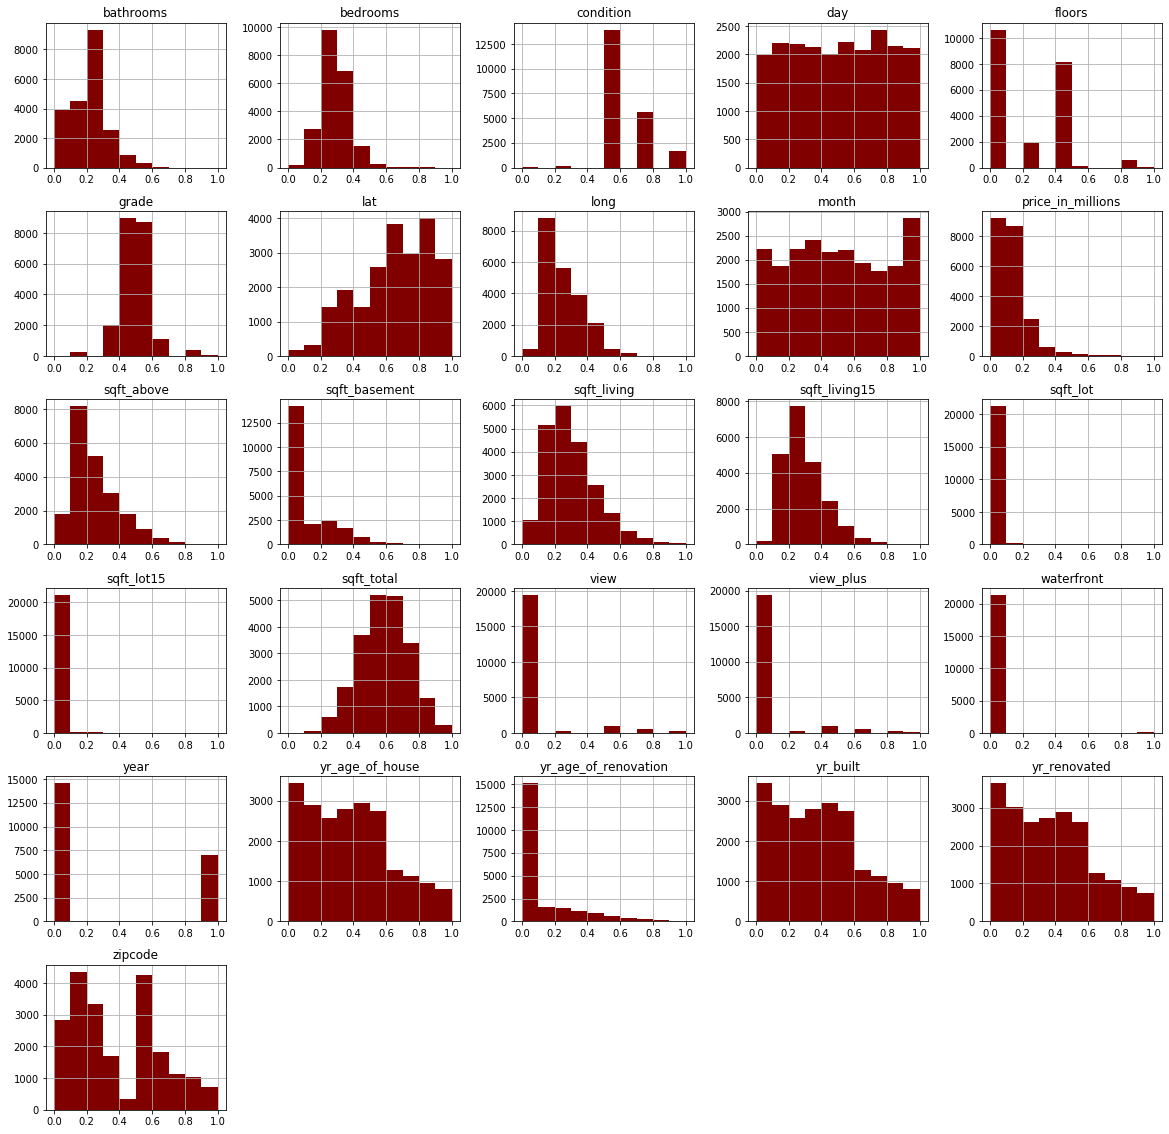

In [39]:
kc1_minmax = pd.DataFrame(mmscaler.fit_transform(kc1[feature_scale]), columns=kc1[feature_scale].columns)
kc1_minmax.hist(figsize = (20,20), color = 'maroon'); 

#### Transforming the train and test set, and add on the id and price variables

In [40]:
mmscaler.transform(kc1[feature_scale]) # checking values in array 

array([[0.2       , 0.07142857, 0.14412811, ..., 0.04305805, 0.41653145,
        0.        ],
       [0.2       , 0.25      , 0.39145907, ..., 0.13764213, 0.69609157,
        0.        ],
       [0.1       , 0.07142857, 0.07117438, ..., 0.03052065, 0.26321733,
        0.        ],
       ...,
       [0.1       , 0.03571429, 0.11565836, ..., 0.09697816, 0.3641989 ,
        0.        ],
       [0.2       , 0.28571429, 0.21886121, ..., 0.09634949, 0.52588907,
        0.        ],
       [0.1       , 0.03571429, 0.11565836, ..., 0.07390784, 0.3641989 ,
        0.        ]])

#### The above array to be converted into DataFrame for Train_Test

In [41]:
kctt = pd.concat([kc1[['id','price']].reset_index(drop=True),
                    pd.DataFrame(mmscaler.transform(kc1[feature_scale]),columns=feature_scale)],
                   axis=1)

In [42]:
kctt.head(2)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,yr_age_of_house,yr_age_of_renovation,price_in_millions,sqft_total,view_plus
0,7129300520,221900.0,0.2,0.071429,0.144128,0.003108,0.0,0.0,0.0,0.5,0.4,0.144128,0.000000,0.517241,0.551724,0.893939,0.571498,0.217608,0.174550,0.005742,0.0,0.818182,0.400000,0.517241,0.000000,0.043058,0.416531,0.0
1,6414100192,538000.0,0.2,0.250000,0.391459,0.004072,0.4,0.0,0.0,0.5,0.4,0.320285,0.140351,0.551724,0.206897,0.626263,0.908959,0.166113,0.239473,0.008027,0.0,1.000000,0.266667,0.551724,0.350877,0.137642,0.696092,0.0


### Multicollinearity : 
*  using heat map for checking multicolinearity between variables

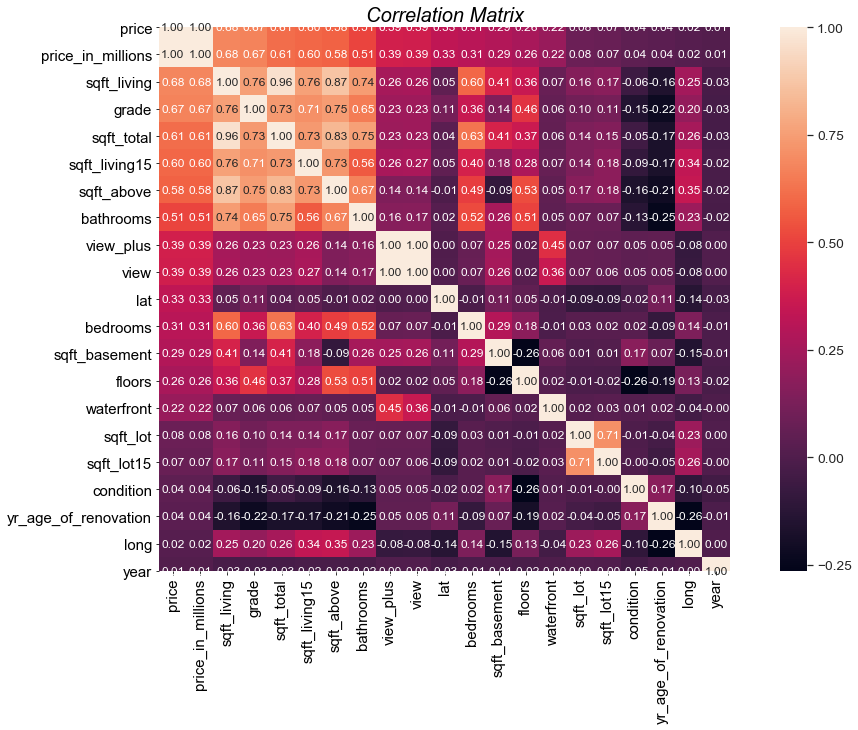

In [43]:
corrmat = kctt.corr()
cols = corrmat.nlargest(21, 'price_in_millions')['price_in_millions'].index #specify number of columns to display i.e 21
f, ax = plt.subplots(figsize=(18, 10)) #size of matrix
cm = np.corrcoef(kctt[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':12}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=90, size=15)
plt.title("Correlation Matrix",style='oblique', size= 20)

plt.show() 

In [44]:
kctt.to_csv('kctt',index=False)   

### Probability distribution

*  Distribution plots are used to show a probality distribution. 
* For a normal distribution, the ideal skewness and kurtosis value is approximately 0.
* Skewness is a measure of the asymmetry of the probability distribution of a random variable about its mean.
* Kurtosis is used to describe the extreme values in one versus the other tail of a distribution.

In [45]:
from sklearn.datasets import make_regression
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr

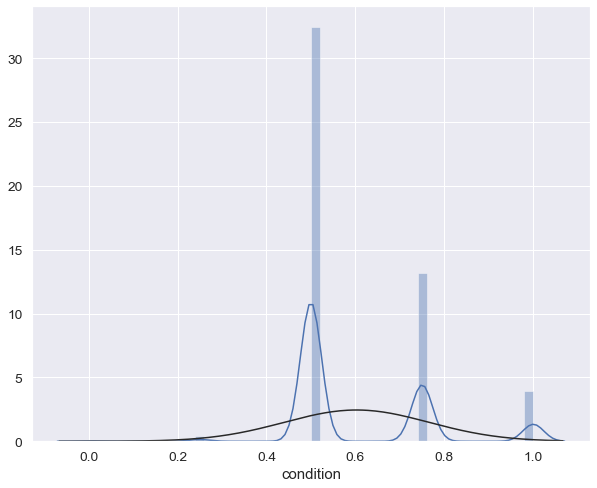

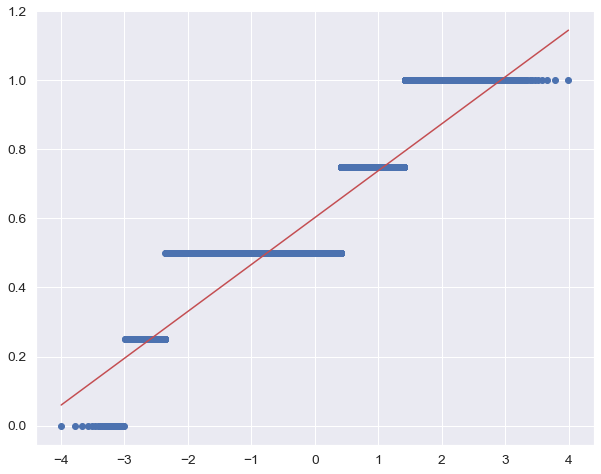

skewness: 1.034395
kurtosis: 0.516626


In [46]:
plt.figure(figsize=(10,8))
# kernel density plot
sns.distplot(kctt.condition,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('Condition Distribution');
(mu,sigma)= norm.fit(kctt['condition']);

#QQ plot
plt.figure(figsize=(10,8))
res = stats.probplot(kctt['condition'], plot=plt)
plt.show()

print("skewness: %f" % kctt['condition'].skew())
print("kurtosis: %f" % kctt ['condition'].kurt()) 


### KDE - Plotting histogram _ to check the distribution of predictors

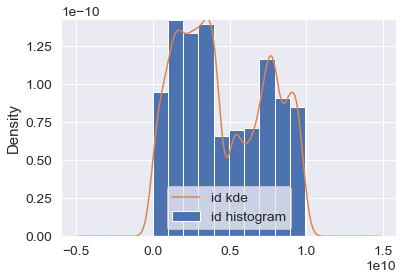

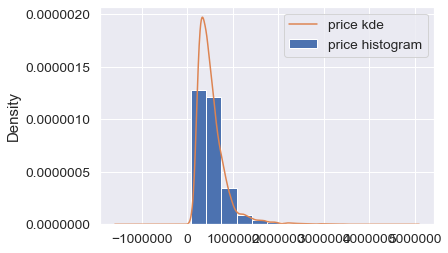

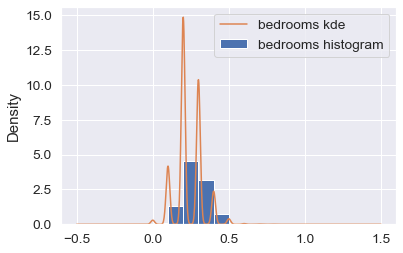

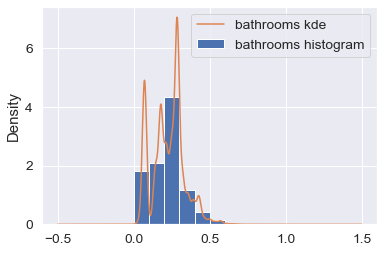

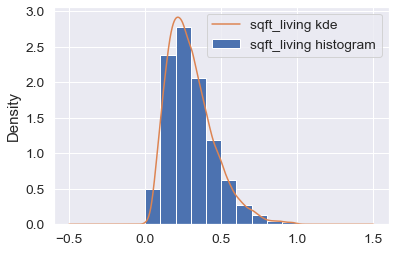

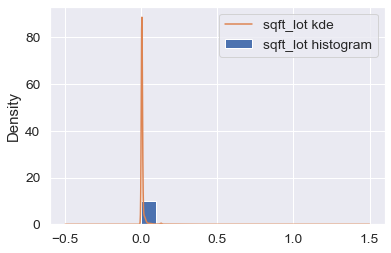

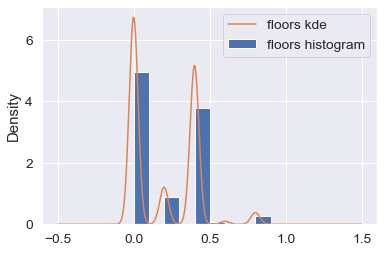

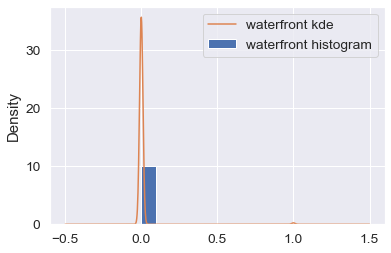

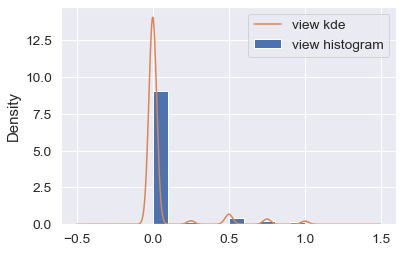

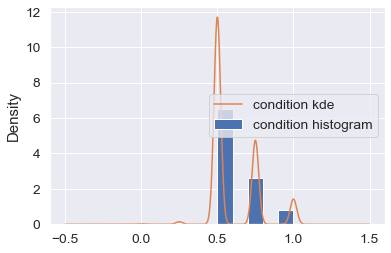

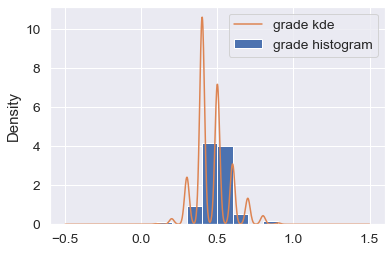

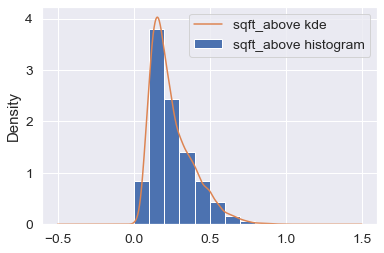

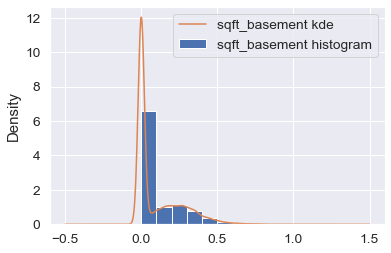

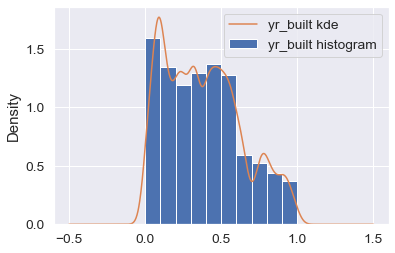

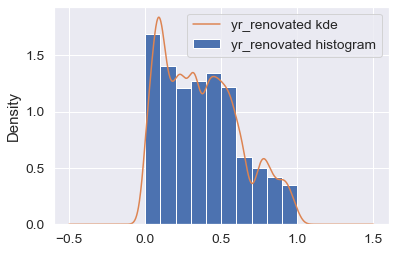

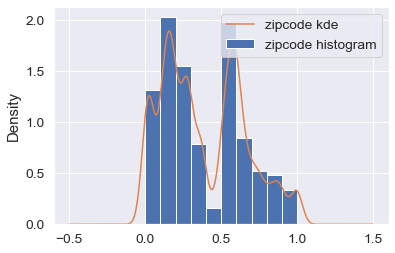

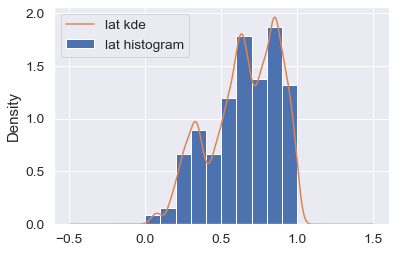

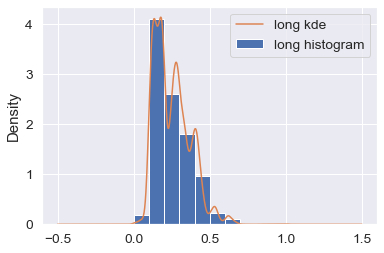

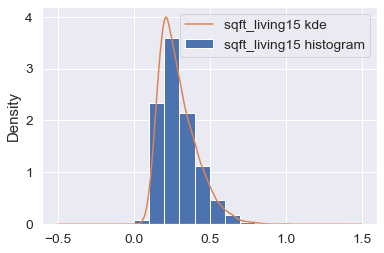

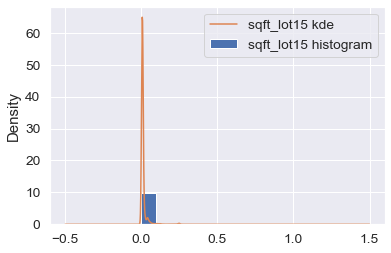

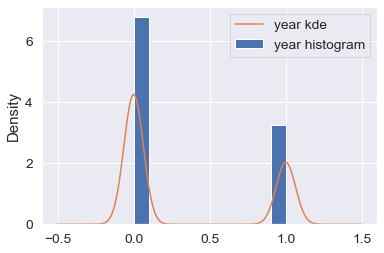

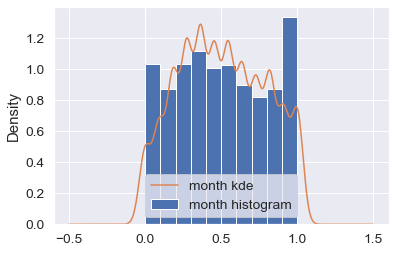

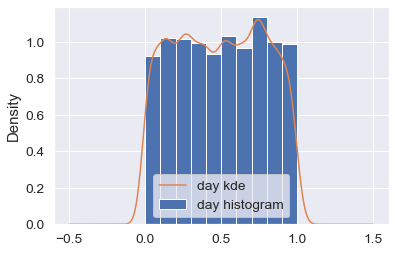

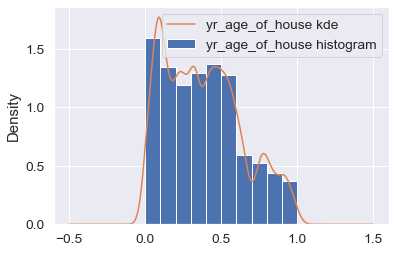

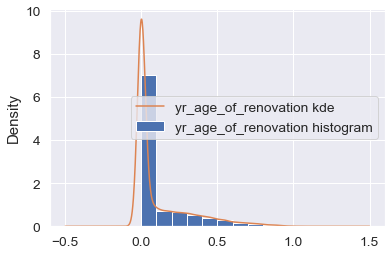

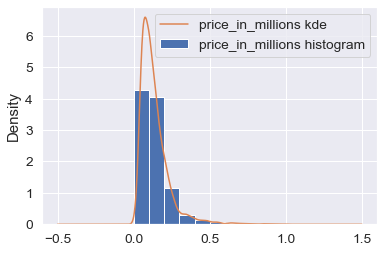

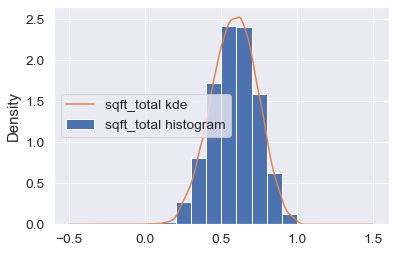

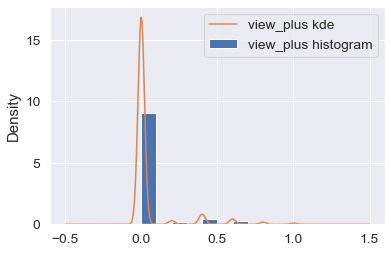

In [47]:
for column in kctt:
    kctt[column].plot.hist(density=True, label = column+' histogram')
    kctt[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

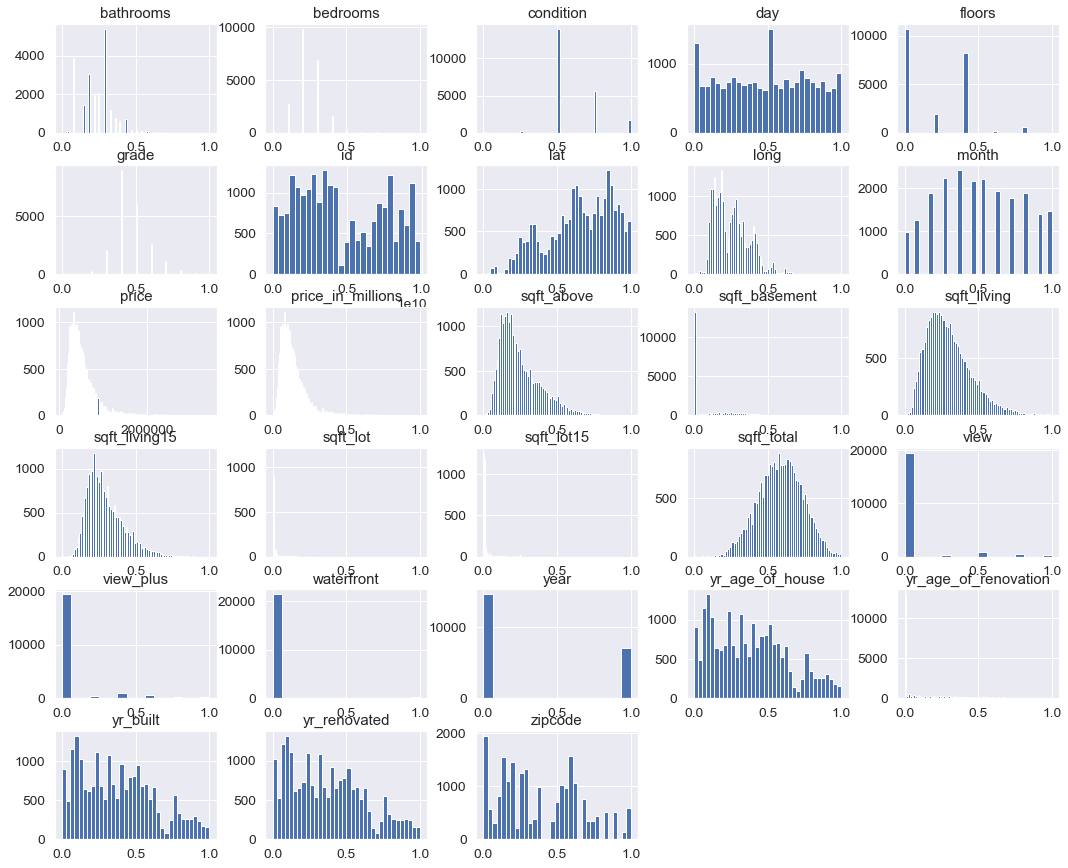

In [49]:
kctt.hist(figsize=(18,15), bins='auto');

### Testing linearity assumption

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

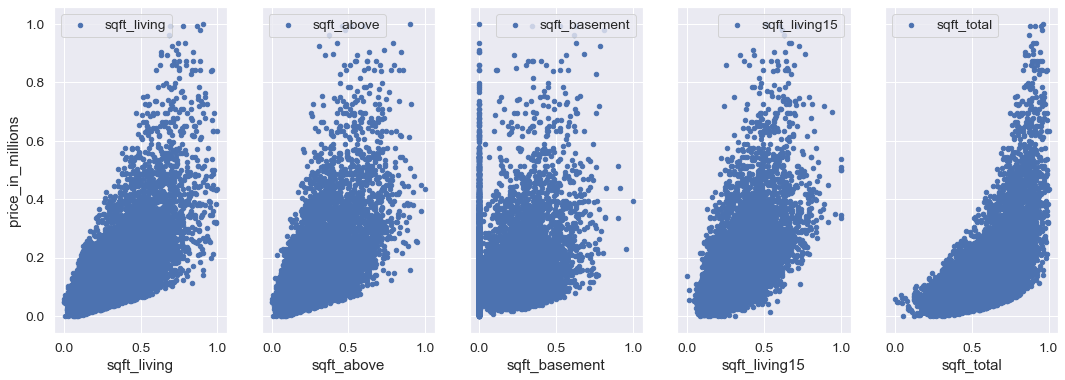

In [50]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(18, 6)) ## 1 line of 4 plots
for idx, age_house in enumerate(['sqft_living', 'sqft_above','sqft_basement', 'sqft_living15','sqft_total']):
    kctt.plot(kind='scatter', x=age_house, y='price_in_millions', ax=axs[idx], label=age_house)
plt.legend() 
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

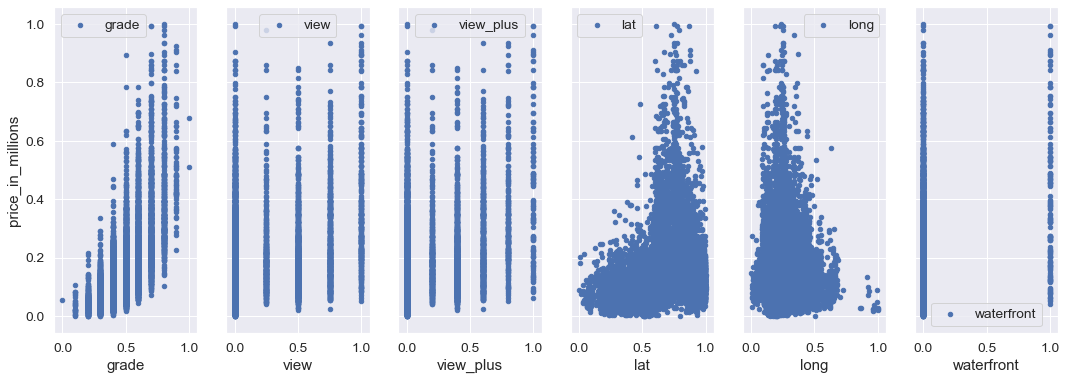

In [51]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize=(18, 6)) ## 1 line of 4 plots
for idx, age_house in enumerate(['grade', 'view','view_plus', 'lat', 'long', 'waterfront']):
    kctt.plot(kind='scatter', x=age_house, y='price_in_millions', ax=axs[idx], label=age_house)
plt.legend() 
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

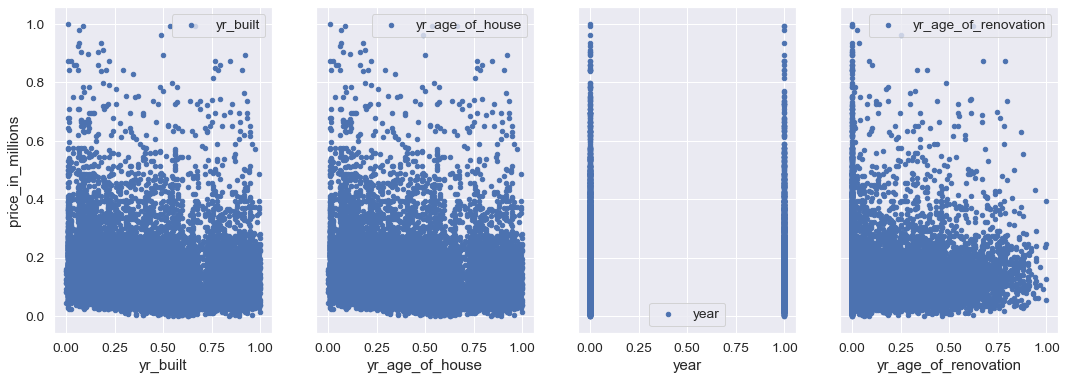

In [52]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 6)) ## 1 line of 4 plots
for idx, age_house in enumerate(['yr_built', 'yr_age_of_house','year', 'yr_age_of_renovation']):
    kctt.plot(kind='scatter', x=age_house, y='price_in_millions', ax=axs[idx], label=age_house)
plt.legend() 
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

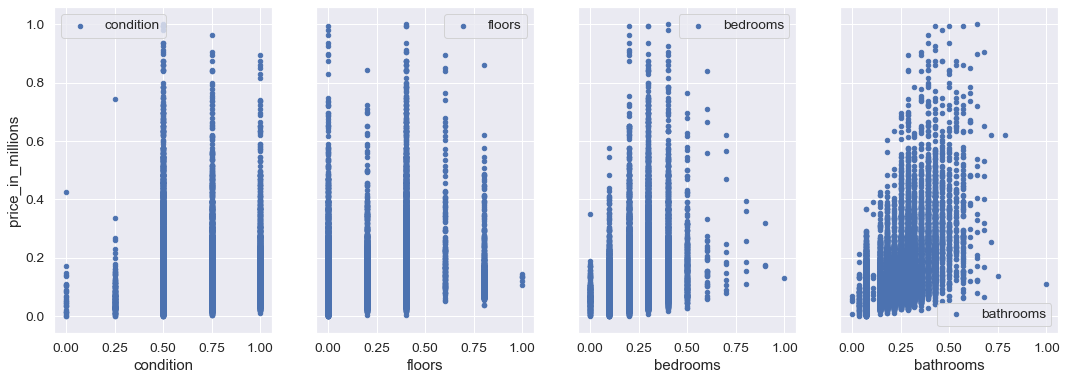

In [53]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 6)) ## 1 line of 4 plots
for idx, age_house in enumerate(['condition','floors','bedrooms', 'bathrooms']):
    kctt.plot(kind='scatter', x=age_house, y='price_in_millions', ax=axs[idx], label=age_house)
plt.legend() 
plt.show()


### Jointplot - Checking for Linearity for
    sqft_living
    view
    grade
    sqft_above
    sqft_basement
    sqft_living15
    sqft_total
    view_plus

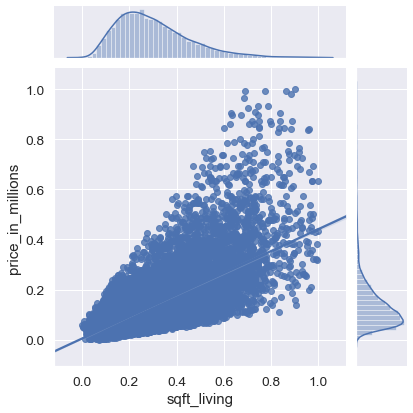

In [54]:
sns.jointplot('sqft_living','price_in_millions', data=kctt, kind='reg'); 

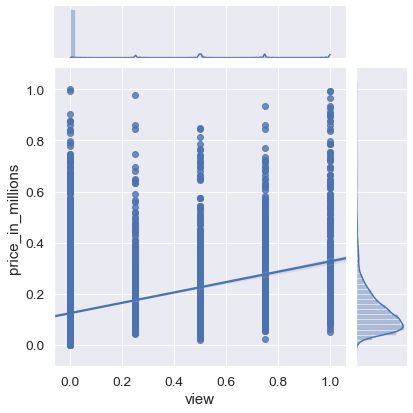

In [55]:
sns.jointplot('view','price_in_millions', data=kctt, kind='reg');

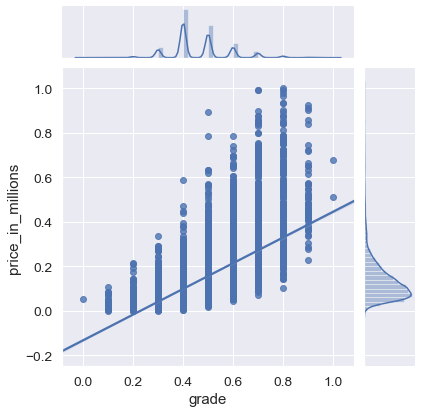

In [56]:
sns.jointplot('grade','price_in_millions', data=kctt, kind='reg');

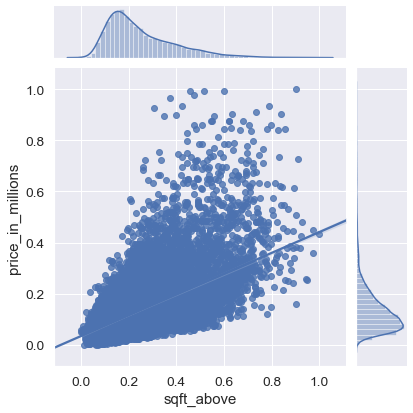

In [57]:
sns.jointplot('sqft_above','price_in_millions', data=kctt, kind='reg');

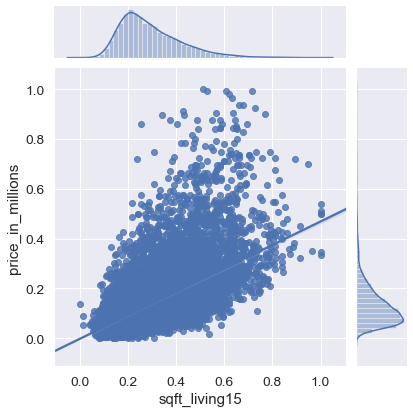

In [58]:
sns.jointplot('sqft_living15','price_in_millions', data=kctt, kind='reg'); 

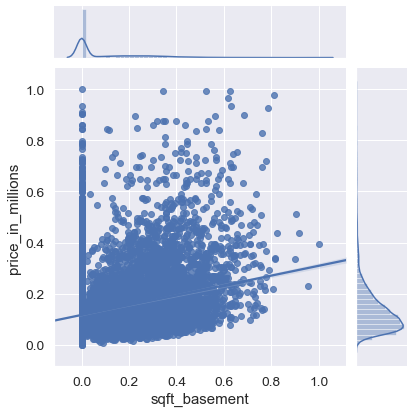

In [59]:
sns.jointplot('sqft_basement','price_in_millions', data=kctt, kind='reg');

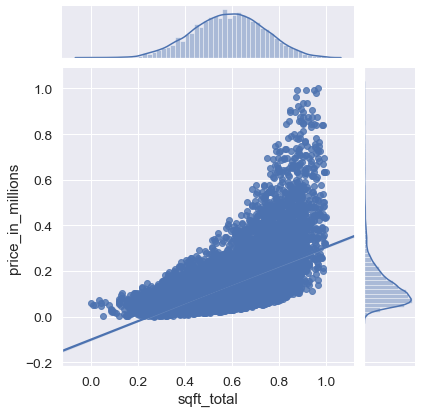

In [60]:
sns.jointplot('sqft_total','price_in_millions', data=kctt, kind='reg');

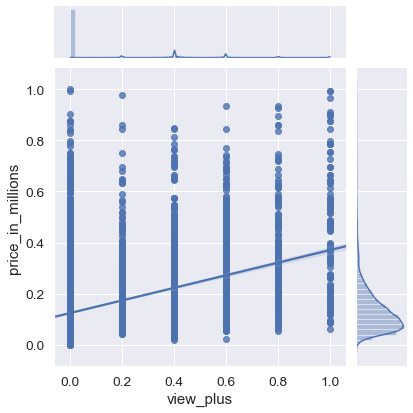

In [61]:
sns.jointplot('view_plus','price_in_millions', data=kctt, kind='reg');

### Jointplot for all column

C:\Users\DELL\anaconda3\envs\learn-env\lib\site-packages\seaborn\axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


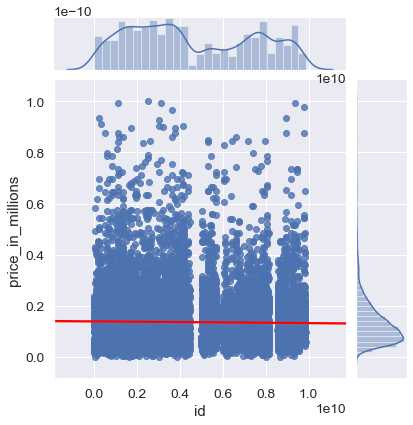

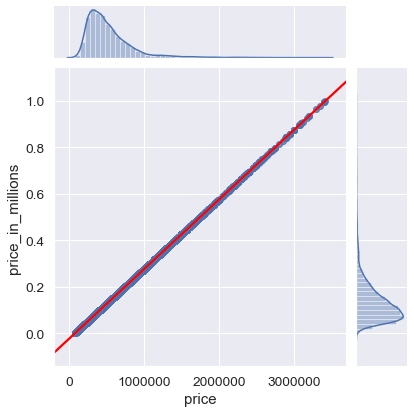

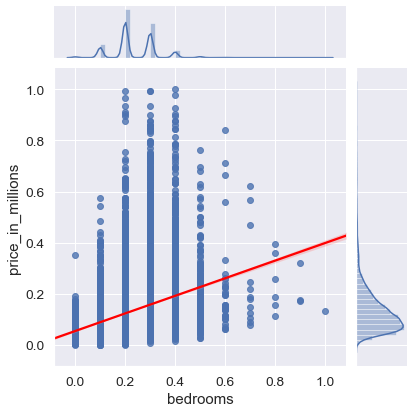

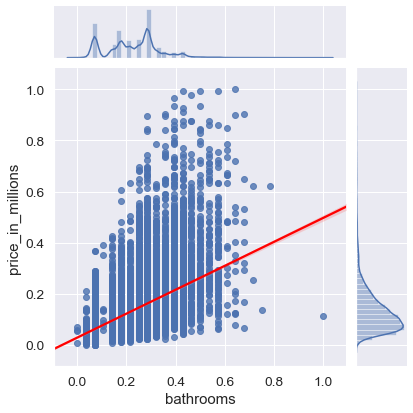

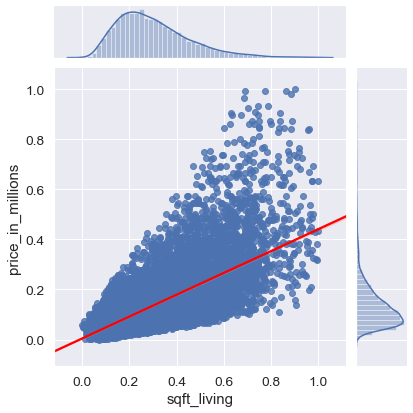

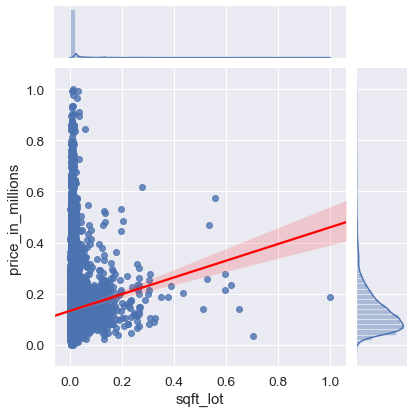

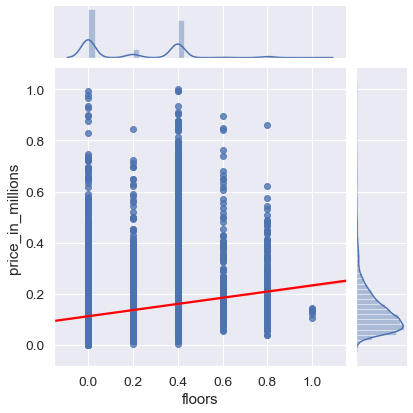

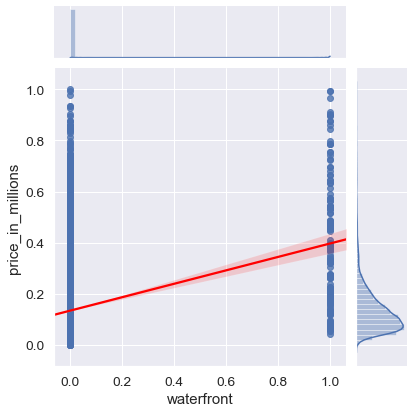

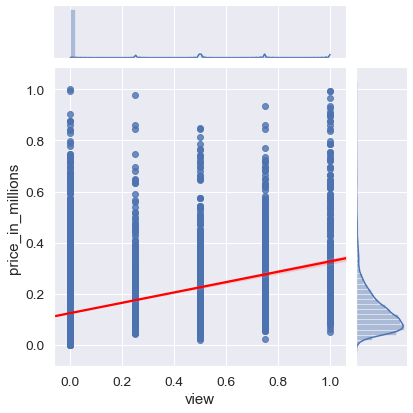

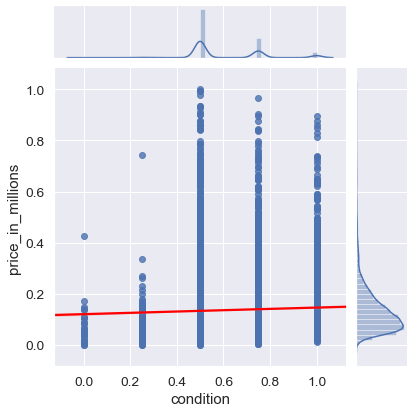

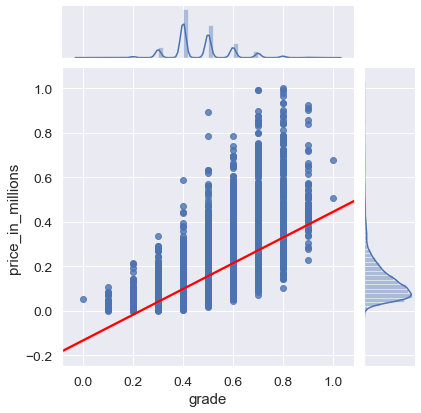

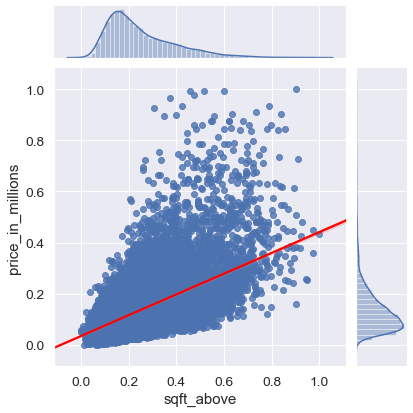

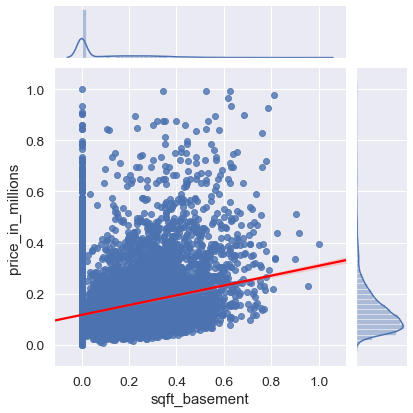

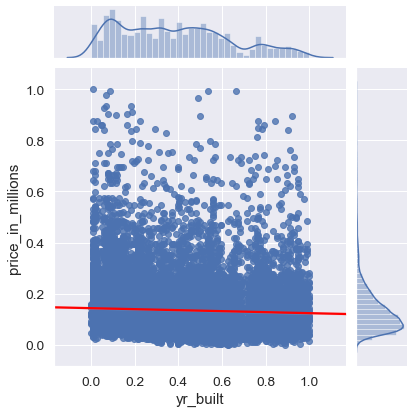

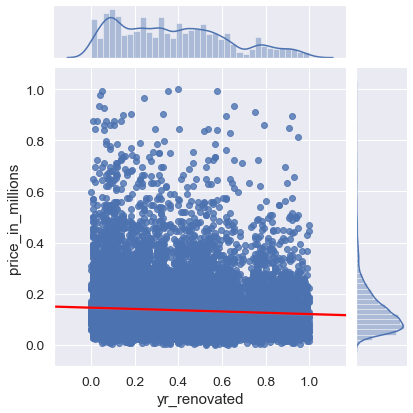

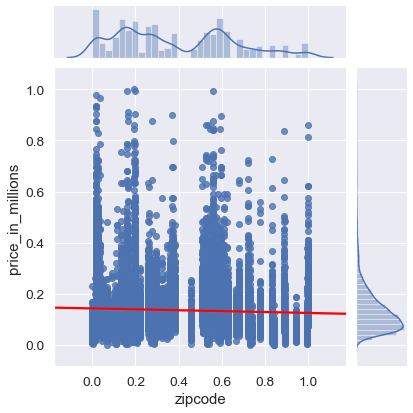

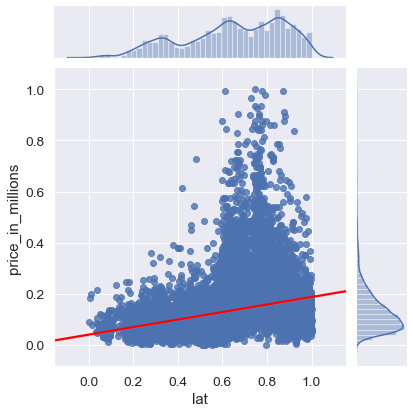

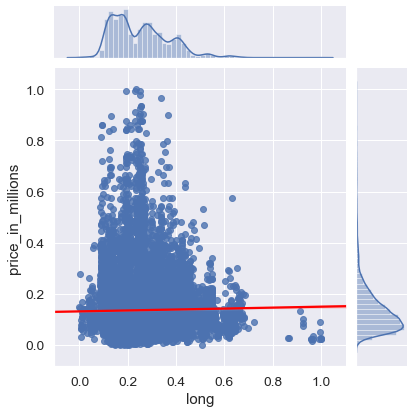

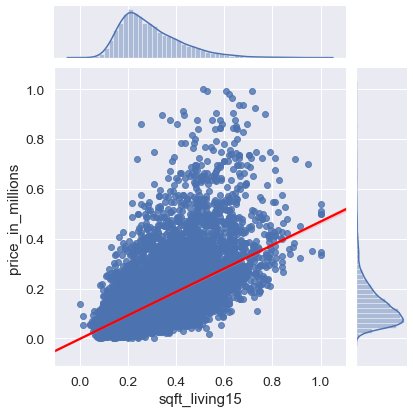

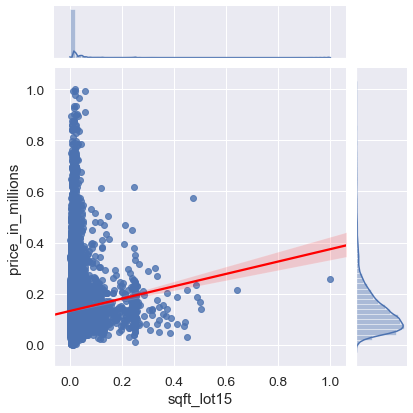

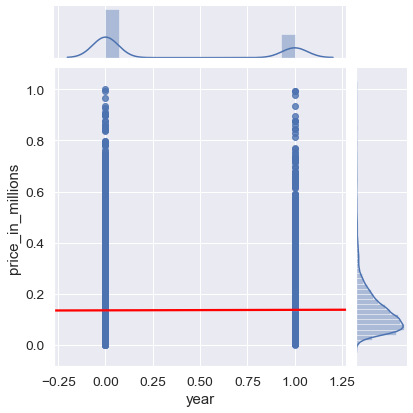

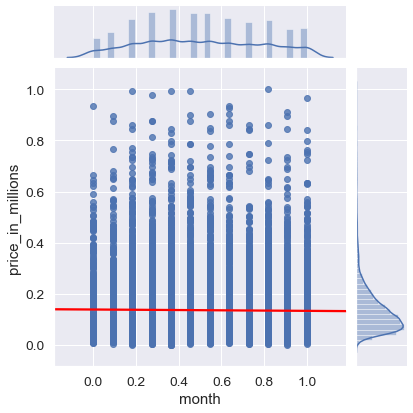

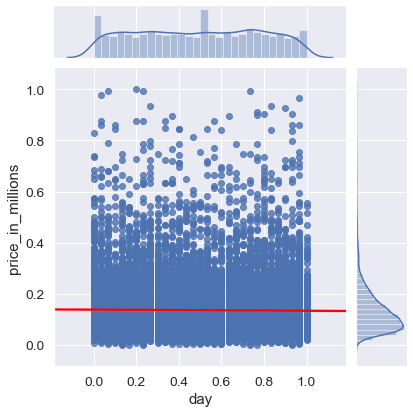

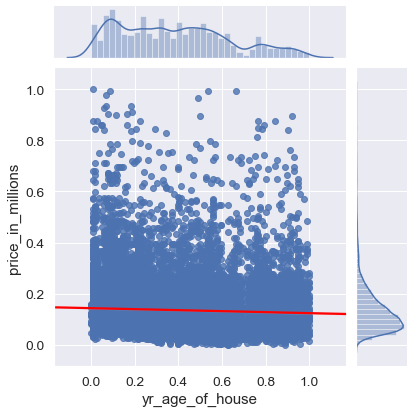

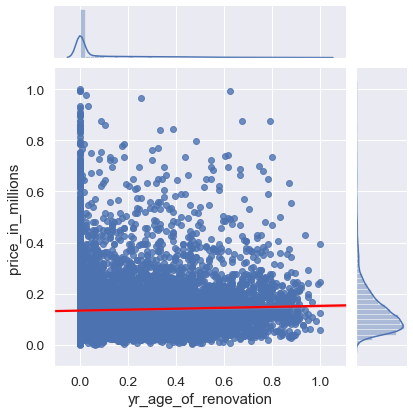

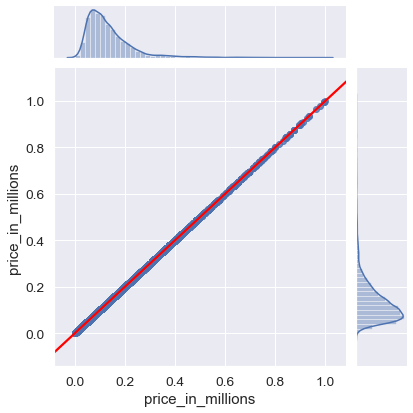

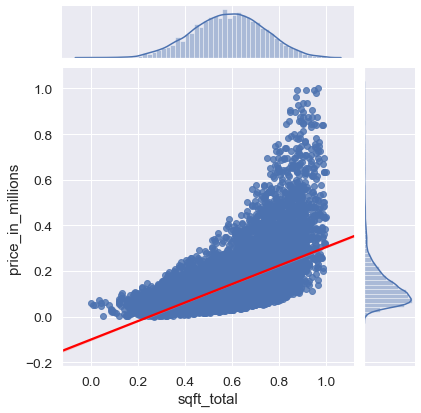

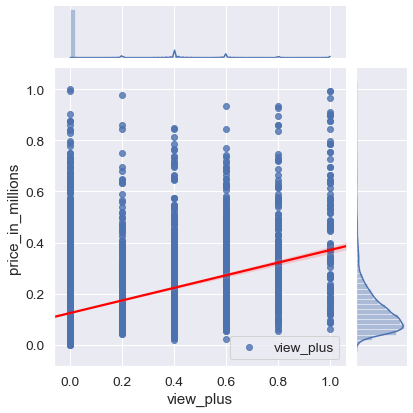

In [62]:
headers = list(kctt)
for column in headers:
    sns.jointplot(x=column, y='price_in_millions',
    data=kctt,
    kind= 'reg',
    label = column,
    joint_kws={'line_kws':{'color':'red'}}) 
plt.legend()
plt.show() 

### Overall Observation
* The following features seems to have a strong Linearity
   - grade
   - sqft_living
   - sqft_above
   - sqft_living15
   - bathrooms
   - sqft_total
   
   
 * The following features may get to Linearity 
   
   - condition
   - bedroom
   - view
   - waterfront
   - view_plus
   - floors
   
   
 * The following features does not have linearity 
   - yr_built
   - yr_renovated
   - year
   - month
   - day
   - yr_age_of_house
   - yr_age_of_renovation
   - sqft_lot
   - sqft_lot15
   - sqft_basement
   - lat
   - long
   - zipcode
   

#### Dropping non-linear features

In [63]:
kctt_drop = ['yr_built','yr_renovated','year','month','day','yr_age_of_house','yr_age_of_renovation','sqft_lot','sqft_lot15',
                 'sqft_basement','lat','long','zipcode']

kctt_linear = kctt.drop(kctt_drop,axis=1)

###  Creating Dummie Variables

In [64]:
dum_list = ['id','waterfront'] 
dum=kctt_linear[dum_list].astype('category')
dummies = pd.get_dummies(dum[dum_list],prefix=dum_list,drop_first=True)
kctt_preprocessed = kctt_linear.drop(dum_list, axis=1)
kctt_preprocessed = pd.concat([kctt_preprocessed,dummies],axis=1)   

### Splitting train & test 

In [66]:
from sklearn.model_selection import train_test_split
y = kctt_preprocessed['price_in_millions']
X = kctt_preprocessed.drop(['price_in_millions'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
X_train.shape, X_test.shape

((17215, 21354), (4304, 21354))

### Model OLS

In [77]:
f = 'price_in_millions~sqft_total+grade+sqft_living15'

In [78]:
model = ols(formula=f, data=kctt).fit()  

In [79]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      price_in_millions   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     6959.
Date:                Thu, 05 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:17:06   Log-Likelihood:                 26524.
No. Observations:               21519   AIC:                        -5.304e+04
Df Residuals:                   21515   BIC:                        -5.301e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1415      0.002    -63.461      0.000      -0.146      -0.137
sqft_total        0.1256      0.005     23.820      0.000       0.115       0.136
grade             0.3587      0.007     54.117      0.000       0.346       0.372
sqft_living15     0.1271      0.006     20.932      0.000       0.115       0.139
==============================================================================
Omnibus:                    11862.884   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163356.657
Skew:                           2.361   Prob(JB):                         0.00
Kurtosis:                      15.645   Cond. No.                         20.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
model.predict() 

array([0.07644691, 0.11980654, 0.05385262, ..., 0.06233089, 0.1277039 ,
       0.06233089])

In [81]:
# create a DataFrame with the minimum and maximum values of sqft_total
X_new = pd.DataFrame({'sqft_total': [kctt.sqft_total.min(), kctt.sqft_total.max()]})
print(X_new.head())
# make predictions for those x values and store them
preds = model.predict(X_new)
print (preds)
# first, plot the observed data and the least squares line
kctt.plot(kind='scatter', x='sqft_total', y='price_in_millions')
plt.plot(X_new, preds, c='red', linewidth=2)
plt.show()

   sqft_total
0         0.0
1         1.0


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'grade' is not defined
    price_in_millions~sqft_total+grade+sqft_living15
                                 ^^^^^

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_total", fig=fig)
plt.show()

In [ ]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show() 

#### Model OLS  : less linear_feature

In [ ]:
# f = 'price_in_millions~condition+view+view_plus+bedrooms+waterfront'

In [ ]:
# model = ols(formula=f, data=kc1).fit()  

In [ ]:
# model.summary()

### Normalization

In [ ]:
# plt.figure(figsize=(18,10))

# #log transform the target 
# kctt["sqft_lot15"] = np.log1p(kctt["sqft_lot15"])

# #Kernel Density plot
# sns.distplot(kctt.sqft_lot15,fit=norm);
# plt.ylabel=('Frequency')
# plt.title=('Square Foot Lot15 distribution');
# #Get the fitted parameters used by the function
# (mu,sigma)= norm.fit(kclr1['sqft_lot15']);



# #QQ plot
# plt.figure(figsize=(18,10))

# res =stats. probplot(kclr1['sqft_lot15'], plot=plt)
# plt.show()
# print("skewness: %f" % kclr1['sqft_lot15'].skew())
# print("kurtosis: %f" % kclr1['sqft_lot15'].kurt())

In [ ]:
# continuous = ['sqft_total', 'sqft_above', 'sqft_living', 'price']
# categoricals = ['condition', 'waterfront','view_plus', 'lat', 'zipcode', 'sqft_living15']
# kctt_cont = kctt[continuous]
# # log features
# log_names = [f'{column}_log' for column in kctt_cont.columns]
# kctt_log = np.log(kctt_cont)
# kctt_log.columns = log_names
# # normalize (subract mean and divide by std)
# def normalize(feature):
#     return (feature-feature.mean())/feature.std()
# kctt_log_norm = kctt_log.apply(normalize)
# # one hot encode categoricals
# kctt_ohe = pd.get_dummies(kctt[categoricals], prefix=categoricals, drop_first=True) 
# preprocessed = pd.concat([kctt_log_norm, kctt_ohe], axis=1)
# X = preprocessed.drop('Price_log', axis=1)
# y = preprocessed['Price_log']